In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
rng = np.random.default_rng()

## chapter 1
### 1. 
generate spikes for 10s using a Poisson spike generator with a constant rate of 100Hz and record their times of occurrence
compute the coefficient of variation of the interspike intervals, and the Fano factor for the spike counts obtained over conting intervals ranging from 1 to 100ms.
plot the ISI histogram

In [3]:
T = 100 # total time, seconds
r = 100 # firing rate, Hz
dt = 1e-3 # timestep, seconds
tmax = int(T/dt) # max time 
t = np.arange(0, tmax) # time vector
rt = dt * r # time dependent firing rate


In [4]:
# generate spikes
spikes = rng.poisson(lam=rt, size=tmax)
spikes[spikes > 1] = 1
# get spike times
spike_times = np.where(spikes)[0]
# get ISI
isi = np.diff(spike_times)

In [5]:
# get coefficient variation
mean_isi = np.mean(isi)
std_isi = np.std(isi)
c_v = std_isi / mean_isi
print(f'Coefficient of variation is: {c_v}')

def get_fano_factor(spikes, window_size):
    """returns fano factor for spike"""
    counts = []
    for i in range(1, int(len(spikes) / window_size + 1)):
        counts.append(sum(spikes[(i - 1) * window_size: (i * window_size)]))

    return np.var(counts) / np.mean(counts)

fano_factors = []
for i in range(1, 101):
    fano_factors.append(get_fano_factor(spikes, i))

Coefficient of variation is: 0.9414949201762334


(0.0, 1.0095720063803204)

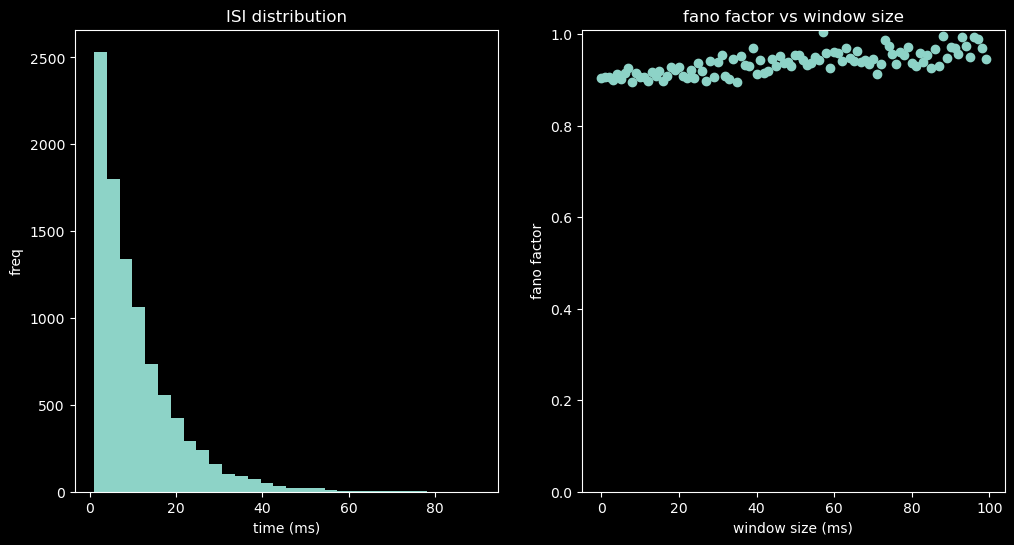

In [6]:
# plot ISI 
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].hist(isi, bins=30)
ax[0].set_title('ISI distribution')
ax[0].set_xlabel('time (ms)')
ax[0].set_ylabel('freq')

ax[1].scatter(np.arange(0, 100, 1), fano_factors)
ax[1].set_title('fano factor vs window size')
ax[1].set_xlabel('window size (ms)')
ax[1].set_ylabel('fano factor')
ax[1].set_ylim(bottom=0)

## 2.
add a refractory period to the Poisson spike generator by allowing the firing rate to depend on time.
- initially, set firing rate to constant value $r(t) = r_0$
- after every spike, set $r(t)$ to 0, and allow it to recover exponentially back to $r_0$ with a time constant $\tau_{ref}$ that controls the refractory rate
- have $r(t)$ obey:
$
\tau_{ref}\frac{dr}{dt} = r_0 - r
$
except immediately after a spike, when it is set to 0.

- plot the coefficient of variation as a function of $\tau_{ref}$ over the range $1\text{ms} \leq \tau_{ref} \leq 20\text{ms}$
- plot ISI histograms for different values of $\tau_{ref}$ in this range
- compute fano factor for spike counts obtained over counting intervals ranging from 1 to 100ms for the case $\tau_{ref}$ = 10ms

In [7]:
r0 = 100 # initial firing rate, Hz

def drdt(r, r0, tau_ref, dt):
    """updates spike generating equation"""
    drdt = (r0 - r) / tau_ref
    return drdt * dt

# initialize firing rate array
r = np.zeros_like(t)
r[0] = r0

# generate spikes function
def refractoriness_spikes(tmax, dt, tau_ref, r0):
    """ generates poisson process spikes with refractoriness"""
    r = np.zeros(tmax)
    r[0] = r0
    # create empty spike vector
    spikes = np.zeros(tmax)
    # iterate through time
    for i in range(1, tmax - 1):
        # if spike condition
        if rng.poisson(lam=r[i - 1]*dt, size=1) > 0:
            # append spike
            spikes[i] = 1
            # set firing rate to 0
            r[i+1] = 0
        else:
            # decay to steady state 
            r[i+1] += drdt(r[i], r0, tau_ref, dt)
    return spikes

# coefficient of variation function
def get_cv(isi):
    return np.std(isi)/np.mean(isi)

In [8]:
tau_ref_list = []
isi_list = []
cv_list = []
for i in range (1, 21):
    tau_ref = i * 1e-3
    tau_ref_list.append(tau_ref)
    spikes = refractoriness_spikes(tmax, dt, tau_ref, r0)
    spike_times = np.where(spikes)[0] * dt
    isi = np.diff(spike_times)
    isi_list.append(isi)
    cv_list.append(get_cv(isi))

In [9]:
# for case where t_ref = 10
tau_ref = 10e-3
spikes = refractoriness_spikes(tmax, dt, tau_ref, r0)

fano_factors = []
for i in range(1, 101):
    fano_factors.append(get_fano_factor(spikes, i))

spike_times = np.where(spikes)[0] * dt
isi = np.diff(spike_times)

(0.0, 1.056857716234581)

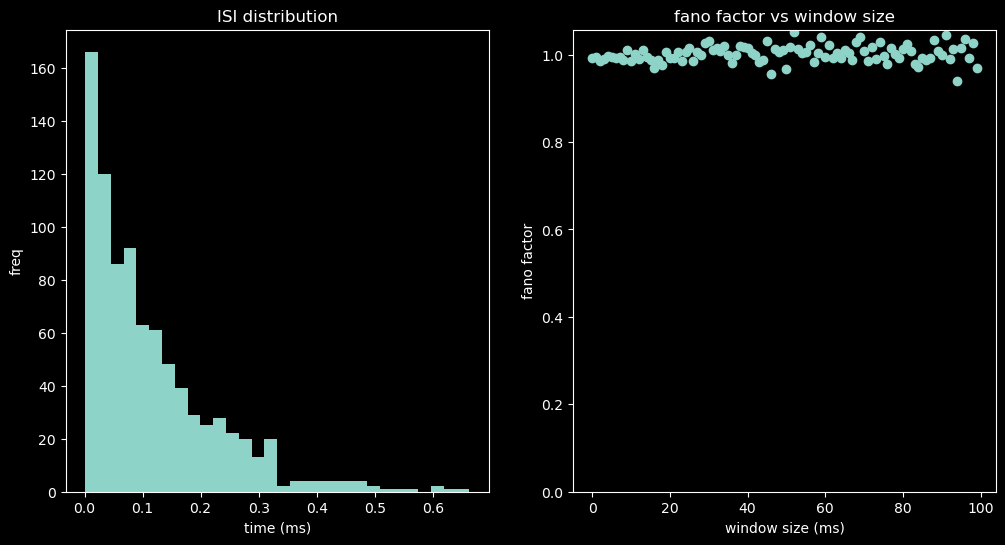

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].hist(isi, bins=30)
ax[0].set_title('ISI distribution')
ax[0].set_xlabel('time (ms)')
ax[0].set_ylabel('freq')

ax[1].scatter(np.arange(0, 100, 1), fano_factors)
ax[1].set_title('fano factor vs window size')
ax[1].set_xlabel('window size (ms)')
ax[1].set_ylabel('fano factor')
ax[1].set_ylim(bottom=0)


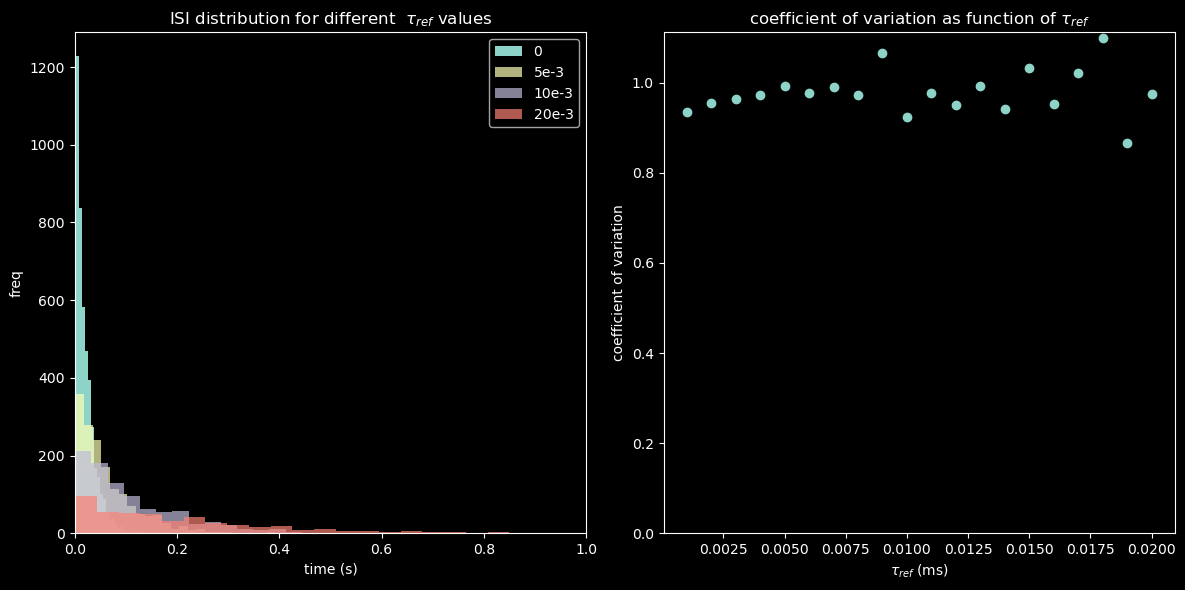

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].hist(isi_list[0],  bins=30, label='0')
ax[0].hist(isi_list[4],  bins=30, label='5e-3', alpha=0.7)
ax[0].hist(isi_list[9],  bins=30, label='10e-3', alpha=0.7)
ax[0].hist(isi_list[19], bins=30, label='20e-3', alpha=0.7)
ax[0].set_title('ISI distribution for different  ' r'$\tau_{ref}$ values')       
ax[0].set_xlabel('time (s)')
ax[0].set_ylabel('freq')    
ax[0].set_xlim(0, 1)
ax[0].legend()

ax[1].scatter(tau_ref_list, cv_list)
ax[1].set_title('coefficient of variation as function of 'r'$\tau_{ref}$')
ax[1].set_xlabel(r'$\tau_{ref}$ (ms)')
ax[1].set_ylabel('coefficient of variation')
ax[1].set_ylim(bottom=0)

plt.tight_layout()

## 3.
compute autocorrelation histograms of spike trains geerated by a Poisson generator with:
- constant firing rate of 100 Hz
- constant firing rate of 100 Hz with refractory period modeled as q2 with $\tau_{ref}$ = 10ms
- variable firing rate:
$r(t) = 100(1 +\cos(2\pi t / 300ms))$ Hz

plot histograms over range from 0 to 100ms

### constant 100hz firing rate

In [12]:
T = 100 # total time, seconds
r = 100 # firing rate, Hz
dt = 1e-3 # timestep, seconds
tmax = int(T/dt) # max time 
t = np.arange(0, tmax) # time vector
rt = dt * r # time dependent firing rate

# generate spikes
spikes = rng.poisson(lam=rt, size=tmax)
spikes[spikes > 1] = 1
# get spike times
spike_times = np.where(spikes)[0]
# get ISI
isi = np.diff(spike_times)

In [13]:
def autocorrelation(spike_train):
    result = np.correlate(spike_train, spike_train, mode='full')
    # autocorrelation is symmetric, so only keep positive time lags
    return result#[result.size // 2:]

In [14]:
autocorr1 = autocorrelation(spikes)
lags = np.arange(-len(autocorr1) // 2 + 1, len(autocorr1) // 2 + 1) * dt

Text(0, 0.5, 'autocorrelation')

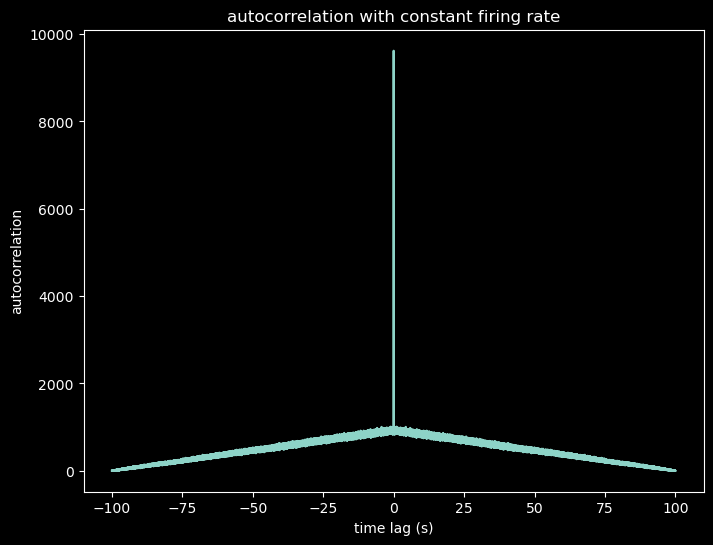

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(lags, autocorr1)
ax.set_title('autocorrelation with constant firing rate')
ax.set_xlabel('time lag (s)')
ax.set_ylabel('autocorrelation')


### refractory and constant 100hz

In [16]:
# for case where t_ref = 10
tau_ref = 10e-3
spikes = refractoriness_spikes(tmax, dt, tau_ref, r0)

autocorr2 = autocorrelation(spikes)
lags = np.arange(-len(autocorr2) // 2 + 1, len(autocorr2) // 2 + 1) * dt


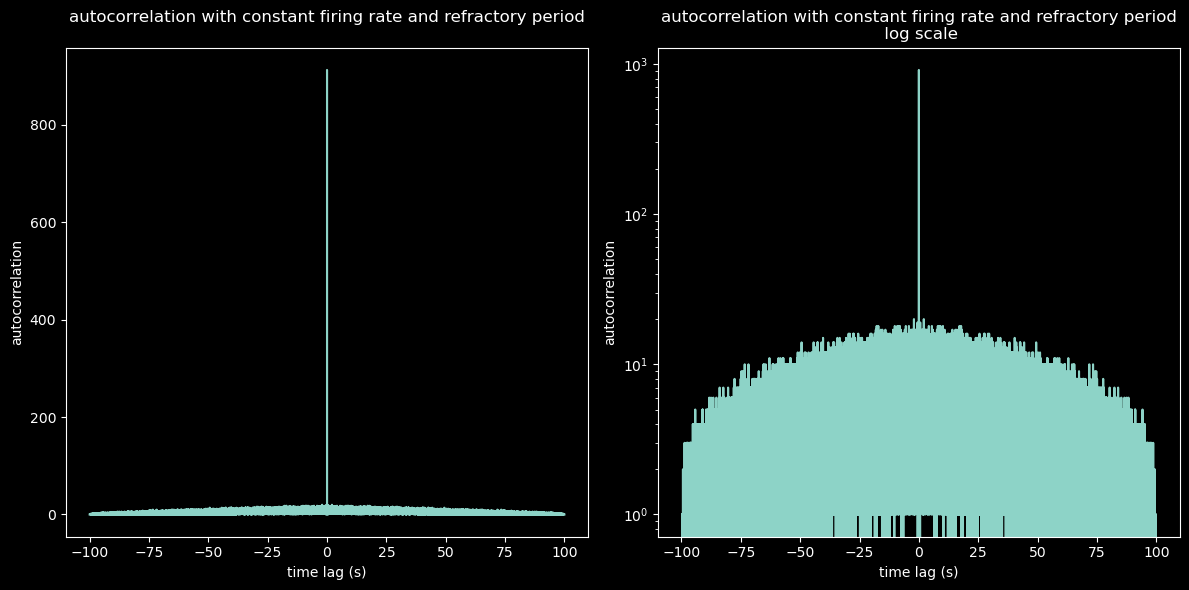

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(lags, autocorr2)
ax[0].set_title('autocorrelation with constant firing rate and refractory period\n')
ax[0].set_xlabel('time lag (s)')
ax[0].set_ylabel('autocorrelation')

ax[1].plot(lags, autocorr2)
ax[1].set_title('autocorrelation with constant firing rate and refractory period\n log scale')
ax[1].set_xlabel('time lag (s)')
ax[1].set_ylabel('autocorrelation')
ax[1].set_yscale('log')

plt.tight_layout()

### variable firing rate

In [18]:
def variable_drdt(t):
    return 100 * (1 + np.cos(2 * np.pi * t*dt / 25e-3))

def variable_spikes(tmax, dt):
    r = np.zeros(tmax)
    r[0] = 100
    spikes = np.zeros(tmax)
    t = np.arange(0, tmax)

    for i in range(1, tmax-1):
        if rng.poisson(lam=r[i-1]*dt, size=1) > 0:
            spikes[i] = 1
        r[i] += variable_drdt(t[i])

    return spikes


In [19]:
spikes = variable_spikes(tmax, dt)
autocorr3 = autocorrelation(spikes)
lags = np.arange(-len(autocorr3) // 2 + 1, len(autocorr3) // 2 + 1) * dt


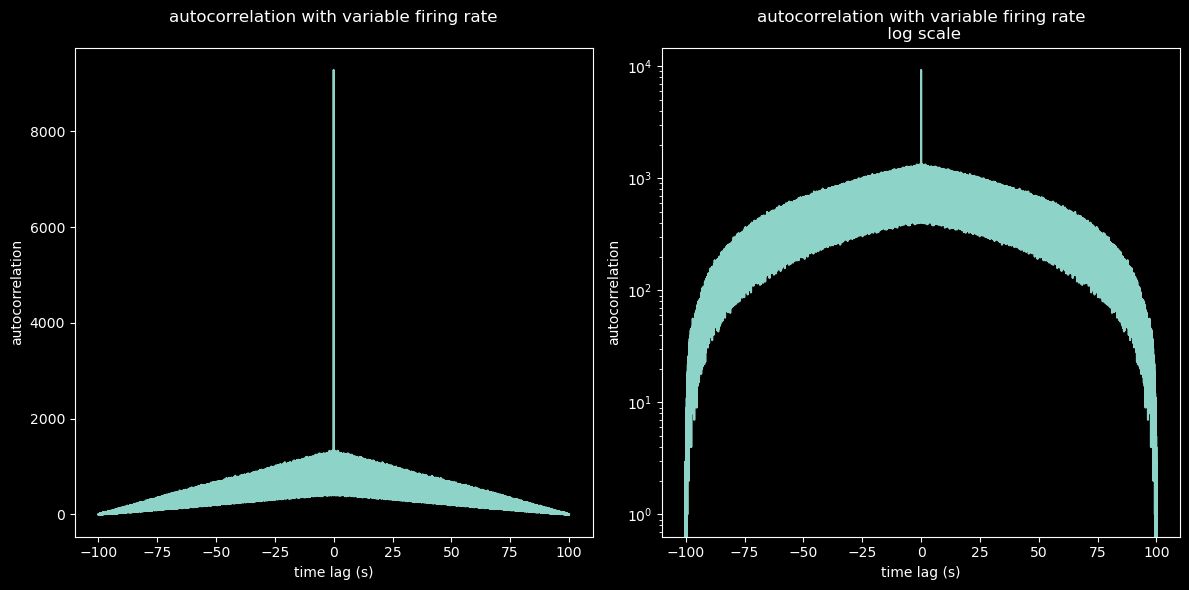

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(lags, autocorr3)
ax[0].set_title('autocorrelation with variable firing rate\n')
ax[0].set_xlabel('time lag (s)')
ax[0].set_ylabel('autocorrelation')

ax[1].plot(lags, autocorr3)
ax[1].set_title('autocorrelation with variable firing rate\n log scale')
ax[1].set_xlabel('time lag (s)')
ax[1].set_ylabel('autocorrelation')
ax[1].set_yscale('log')

plt.tight_layout()

Text(0.5, 1.0, 'autocorrelation with variable firing rate')

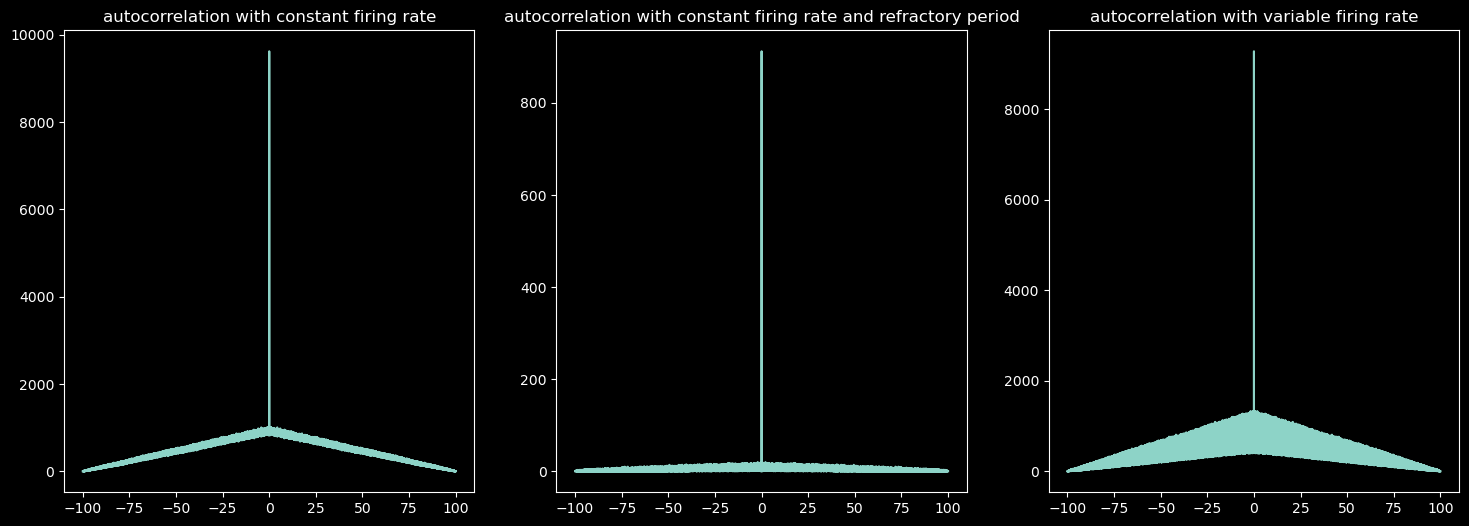

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].plot(lags, autocorr1)
ax[1].plot(lags, autocorr2)
ax[2].plot(lags, autocorr3)

ax[0].set_title('autocorrelation with constant firing rate')
ax[1].set_title('autocorrelation with constant firing rate and refractory period')
ax[2].set_title('autocorrelation with variable firing rate')

In [22]:
# get autocorrelation values for only positive lags
pos1 = autocorr1[int(np.ceil(autocorr1.size/2)):][0:100]
pos2 = autocorr2[int(np.ceil(autocorr2.size/2)):][0:100]
pos3 = autocorr3[int(np.ceil(autocorr3.size/2)):][0:100]

x = np.linspace(1, len(pos1), len(pos1))
x3 = np.linspace(1, len(pos3), len(pos3))

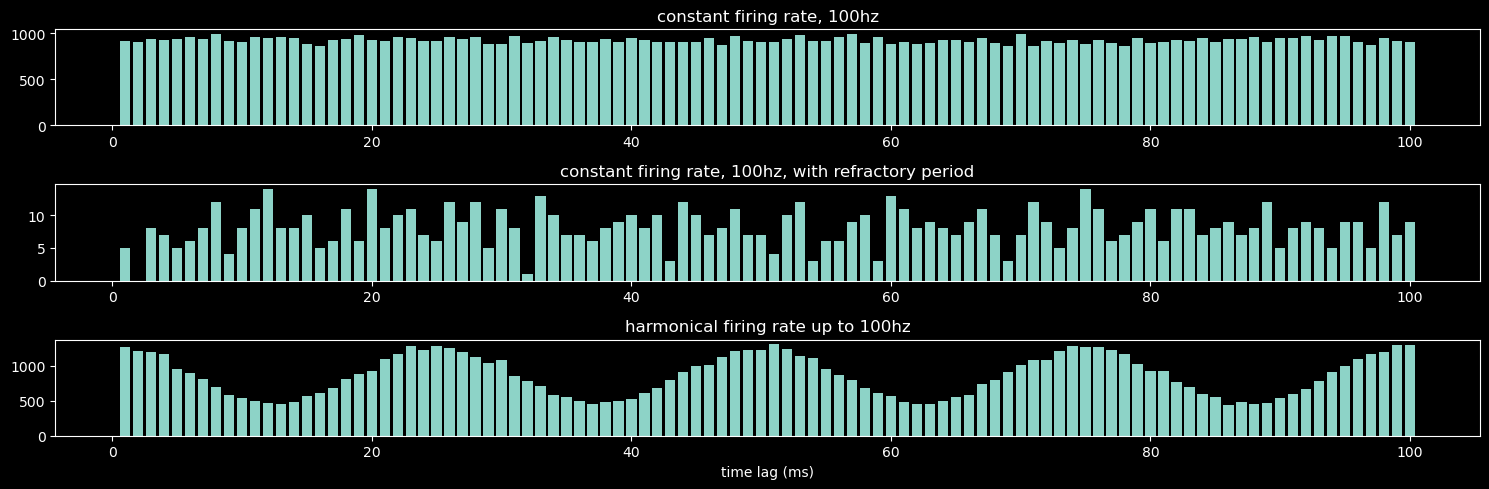

In [23]:
fig, ax = plt.subplots(3, 1, figsize=(15, 5))

ax[0].bar(x, pos1)
ax[0].set_title('constant firing rate, 100hz')
ax[1].bar(x, pos2)
ax[1].set_title('constant firing rate, 100hz, with refractory period')
ax[2].bar(x3, pos3)
ax[2].set_title('harmonical firing rate up to 100hz')

ax[2].set_xlabel('time lag (ms)')

plt.tight_layout()

## 4
generate a poisson spike train with a time-dependent firing rate
$ r(t) = 100(1 + \cos(2 \pi t / 300\text{ms})) $ Hz

approximate the firing rate from this spike train using a variable $r_{approx}$ that satisfies 
$ \tau_{approx} \frac {d r_{approx}}{dt} = -r_{approx} $

except that $r_{approx} \rightarrow r_{approx} + 1/ \tau_{approx} $ every time a spike occurs

make plots of:
    - true rate
    - spike sequence generated
    - estimated rate

experiment with different values of $\tau_{approx}$ in the range of 1 to 100ms

determine the best value of $\tau_{approx}$ by computing the average squared error of the estimate:


$\int dt(r(t) - r_{approx}(t))^2$ for different values of $\tau_{approx}$ and finding the value of $\tau_{approx}$ that minimizes this error

In [24]:
T = 10  # seconds
tmax = int(T/dt)
dt = 1e-3   # timestep, seconds
t = np.arange(0, tmax)

def variable_drdt(t):
    return 100 * (1 + np.cos(2 * np.pi * t*dt / 300e-3))

def variable_spikes(tmax, dt):
    r = np.zeros(tmax)
    r[0] = 100
    spikes = np.zeros(tmax)

    for i in range(1, tmax-1):
        if rng.poisson(lam=r[i-1]*dt, size=1) > 0:
            spikes[i] = 1
        r[i] += variable_drdt(t[i])

    return spikes

spikes = variable_spikes(tmax, dt)

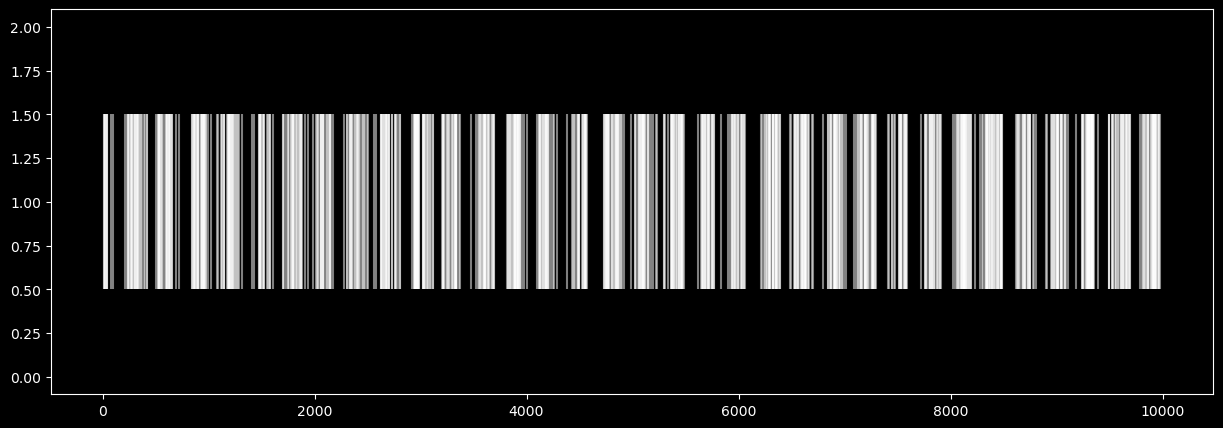

In [25]:
# visualize spikes 
spike_times = np.where(spikes)
spike_times = np.asarray(spike_times[0])
fig, ax = plt.subplots(figsize=(15, 5))
ax.eventplot(spike_times, alpha=0.5)

In [26]:
def get_r_approx(spikes, dt, tau_approx):
    """calculate approx firing rate from spike train"""
    r_approx = np.zeros_like(spikes)

    for i in range(1, len(spikes)):
        spike_contribution = 1 / tau_approx if spikes[i] > 0 else 0
        r_approx[i] = r_approx[i - 1] * np.exp(-dt / tau_approx) + spike_contribution
    return r_approx

In [27]:
tau_vals = np.arange(1e-3, 111e-3, 10e-3)

r_approx_list = []

for tau in tau_vals:
    r_approx_list.append(get_r_approx(spikes, dt, tau))

In [28]:
df = pd.DataFrame(zip(tau_vals, r_approx_list))
df.rename(columns={0: 'tau', 1: 'r_approx'}, inplace=True)

In [29]:
true_rate = variable_drdt(t)

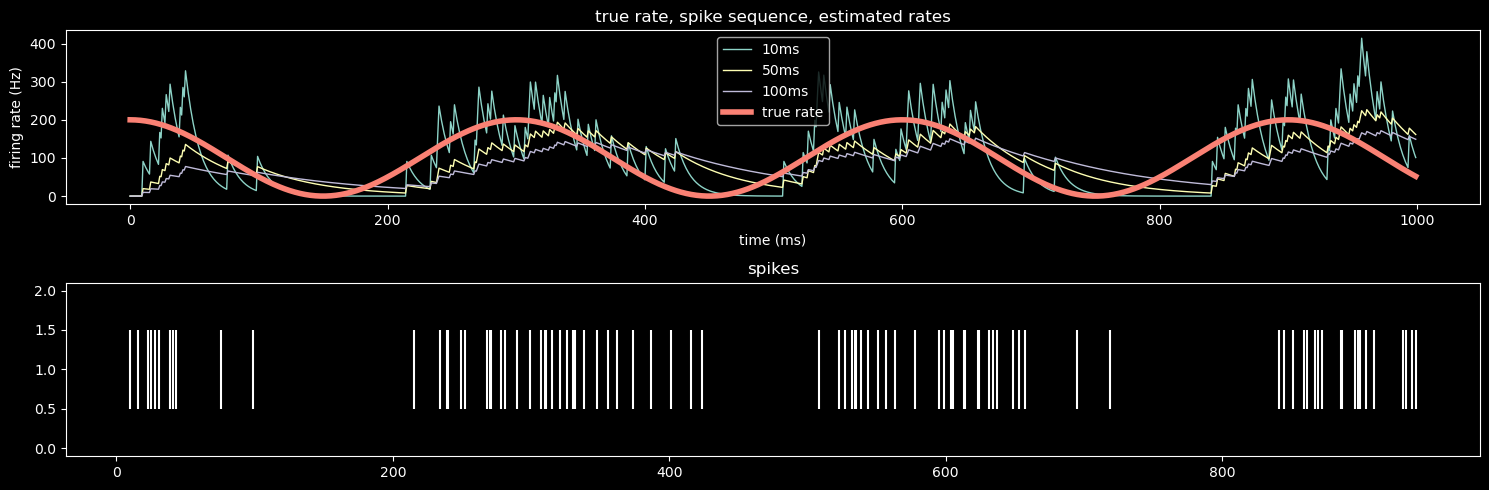

In [30]:
fig, ax = plt.subplots(2, 1, figsize=(15, 5))

ax[0].plot(df['r_approx'][1][:1000], linewidth=1, label='10ms')
ax[0].plot(df['r_approx'][5][:1000], linewidth=1, label='50ms')
ax[0].plot(df['r_approx'][10][:1000], linewidth=1, label='100ms')
ax[0].plot(true_rate[:1000], linewidth=4, label='true rate')

ax[0].set_ylabel('firing rate (Hz)')
ax[0].set_xlabel('time (ms)')
ax[0].set_title('true rate, spike sequence, estimated rates')

ax[1].eventplot(spike_times[:88])  # to get x axes to line up
ax[1].set_title('spikes')

ax[0].legend()

plt.tight_layout()

In [31]:
df['square_error'] = df['r_approx'].apply(lambda r: np.sum((r - true_rate) ** 2))
print(f"value of tau best approximating firing rate is: {np.round(df.loc[df['square_error'].idxmin(), 'tau'], 2)} s")

value of tau best approximating firing rate is: 0.02 s


Text(0, 0.5, 'square error')

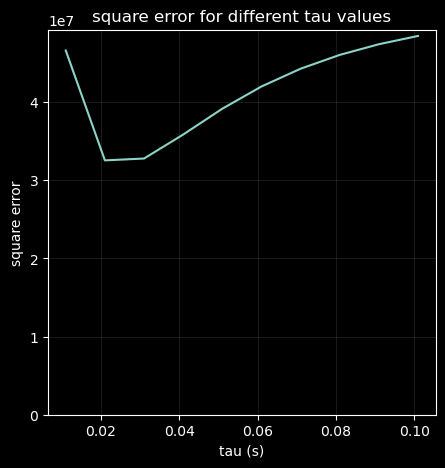

In [32]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(df['tau'][1:], df['square_error'][1:])
ax.set_ylim(0)
ax.grid(which='both', alpha=0.1)
ax.set_title('square error for different tau values')
ax.set_xlabel('tau (s)')
ax.set_ylabel('square error')

## 5
for constant rate poisson process, every specific (up to finite resolution) sequence of N spikes occuring over a given interval is equally likely
- seems paradoxical... resolve

each spike occurs at constant rate, poisson process is memoryless, each sequence is equally probable 

## 6
build an approximate white-noise stimulus by choosing random values at discrete times separated by a time-step interval dt
- plot it's autocorrelation function and powerspectrum 
- discuss how well the stimulus matches an ideal white-noise stimulus given the value of dt used

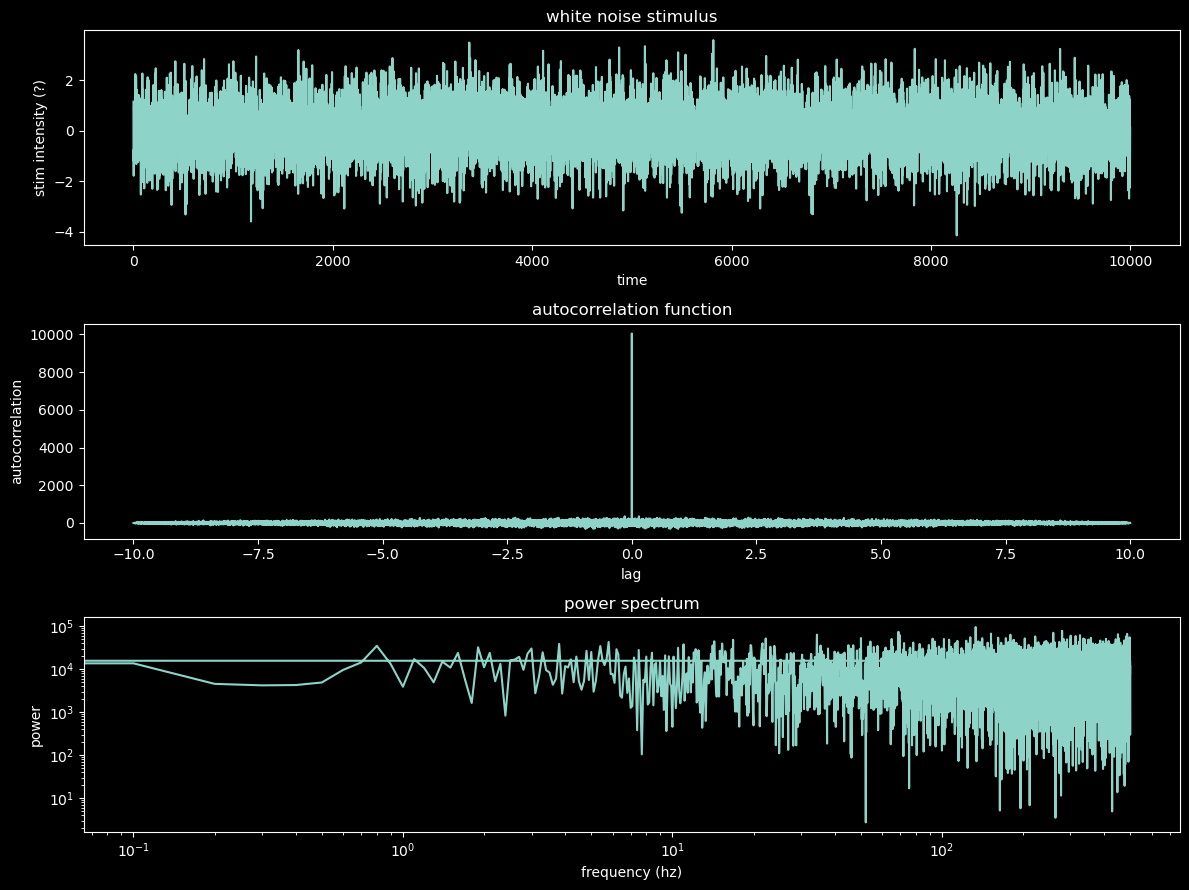

In [33]:
from scipy.fft import fft

# generate stimulus
dt = 1e-3
T = 10
tmax = int(T/dt)
time_steps = np.arange(0, T, dt)
white_noise = np.random.normal(0, 1, size=tmax)

# plot
fig, ax = plt.subplots(3, 1, figsize=(12, 9))
# plot white noise
ax[0].plot(white_noise)
ax[0].set_title('white noise stimulus')
ax[0].set_xlabel('time')
ax[0].set_ylabel('stim intensity (?)')

# plot autocorrelation
autocorr = np.correlate(white_noise, white_noise, mode='full')
lags = np.arange(-len(white_noise)+1, len(white_noise))
ax[1].plot(lags*dt, autocorr)
ax[1].set_xlabel('lag')
ax[1].set_ylabel('autocorrelation')
ax[1].set_title('autocorrelation function')

# plot power spectrum
power_spectrum = np.abs(fft(white_noise)) ** 2
freqs = np.fft.fftfreq(len(white_noise), d=dt)
ax[2].loglog(freqs, power_spectrum)
ax[2].set_title('power spectrum')
ax[2].set_ylabel('power')
ax[2].set_xlabel('frequency (hz)')


plt.tight_layout()

## 7
consider a model with a firing rate determined in terms of a stimulus $s(t)$ by integrating the equation:
$$
\tau_r \frac{dr_{est}(t)}{dt} = [r_0 + s]_+ - r_{est}(t)
$$

where $r_0$ is a constant that determines the background firing rate and $\tau_r$ = 20ms

- drive the model with an approximate white noise stimulus
- adjust the amplitude of the white-noise and the parameter $r_0$ so that rectification is not a big effect (i.e., $r_0 + s \lt 0$ most of the time) 
- from the model responses, compute the stimulus-response correlation function, $Q_{rs}$ 

- next, generate spikes from the model using a poisson generator with a rate $r_{est}(t)$ and compute the STA for the stimuus

- by comparing the stimulus-response correlation function with the STA, verify that equation 1.22 is satisfied
- examine what happens if you set $r_0 = 0$ so that the white-noise stimulus becomes half-wave rectified


In [34]:
tau_r = 20e-3
r0 = 2
r0_alt = 0
dt = 1e-3
tmax = 50
t = np.arange(0, tmax, dt)
noise_amp = 3

# generate white noise stim
s = np.random.normal(0, 1, size=len(t)) * noise_amp

def drdt(r_est, tau_r, r0, s, rectify=False):
    input = r0 + s
    if rectify:
        input = max(0, input)
    return r_est + (input - r_est) * (dt/tau_r)

def run_noise_sim(r0, t, s, rectify=False):
    """run simulation with noise"""
    r_est = np.ones_like(t) * r0
    for i in range(1, len(t)):
        r_est[i] = drdt(r_est[i-1], tau_r, r0, s[i-1], rectify)

    return r_est

unrectified = run_noise_sim(r0, t, s)
rectified = run_noise_sim(r0, t, s, rectify=True)


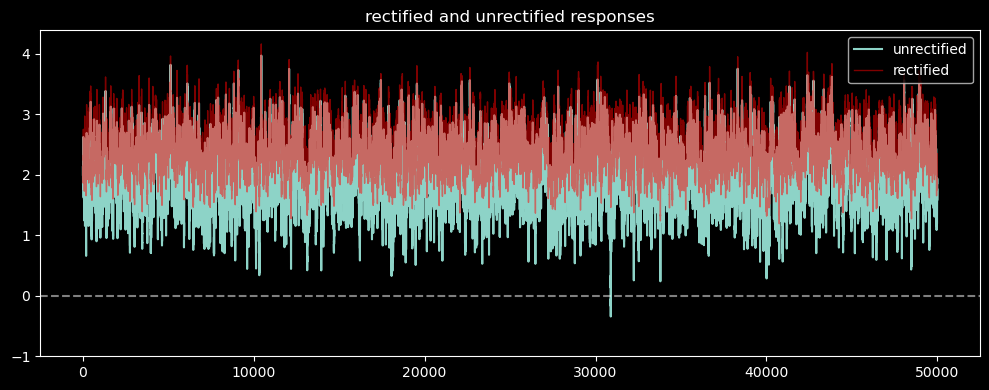

In [35]:
# makes sense bc remains constant without input stimulus?

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(unrectified, label='unrectified')
ax.set_title('rectified and unrectified responses')
ax.plot(rectified, label='rectified', alpha=0.5, linewidth=1, c='r')
ax.set_ylim(-1)
ax.axhline(0, linestyle='--', alpha=0.5)
ax.legend(loc='upper right')
plt.tight_layout()

In [36]:
# get correlation function
r_est = unrectified
lags = np.arange(-len(r_est)+1, len(r_est))*dt
qrs = np.correlate(r_est, noise_amp*s[:len(r_est)], mode='full') / len(r_est)


Text(0.5, 1.0, 'stim-response correlation function')

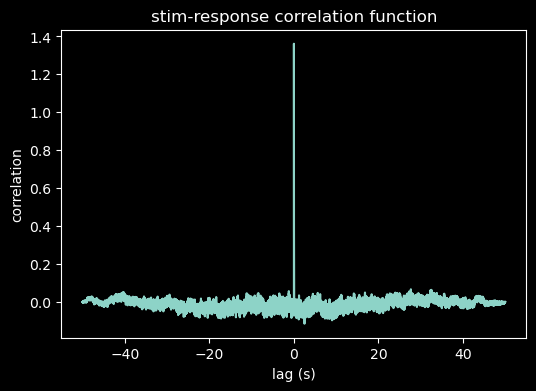

In [37]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(lags, qrs)
ax.set_xlabel('lag (s)')
ax.set_ylabel('correlation')
ax.set_title('stim-response correlation function')

In [48]:
# get spikes and STA
spikes = rng.poisson(lam=rectified, size=len(t))
spikes[spikes > 1] = 1
# window size and steps
window = 100e-3
window_steps = int(window/dt)
# initialize
sta_sum = np.zeros(window_steps)
num_spikes = np.sum(spikes)

# loop through spike train
for i in range(window_steps, len(spikes)):
    if spikes[i] == 1:
        # add stimulus preceding spike

        sta_sum += s[i - window_steps:i]
# get aveage
sta = sta_sum / num_spikes

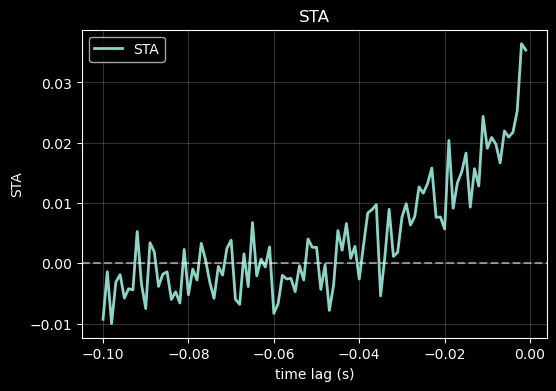

In [49]:
fig, ax = plt.subplots(figsize=(6, 4))

time_lags = np.linspace(-window, 0, window_steps, endpoint=False)

ax.plot(time_lags, sta, label='STA', linewidth=2)
ax.set_xlabel('time lag (s)')
ax.set_ylabel('STA')
ax.set_title('STA')
ax.grid(which='both', alpha=0.2)
ax.axhline(0, linestyle='--', alpha=0.5)
ax.legend()

## 8
c1p8.mat contains data collected from a fly H1 neuron responding to an approximate white noise visual motion stimulus
- collected for 20min at a sampling rate of 500Hz
- `rho` is a vector that gives the sequence of spiking events or nonevents at the sampled times (every 2ms)
- when an element of `rho` is 1, this indicates a spike at that time, whereas 0 indicates no spike
- `stim` gives sequence of stimulus values at sampled times
- calculate and plot STA from these data over the range from 0 to 300ms (150 timesteps)

In [50]:
data = pd.read_csv('C1P8.csv', header=None)
data.rename(columns={0: 'rho', 1: 'stim'}, inplace=True)
data.head()

,rho,stim
0,0,-111.948242
1,0,-81.806641
2,0,10.219727
3,0,83.364258
4,0,69.375000


In [51]:
dt8 = 2e-3
lags = np.arange(-len(data)+1, len(data))
qrs = np.correlate(data['rho'], data['stim'], mode='full') / len(data)

Text(0.5, 1.0, 'stim-response correlation function')

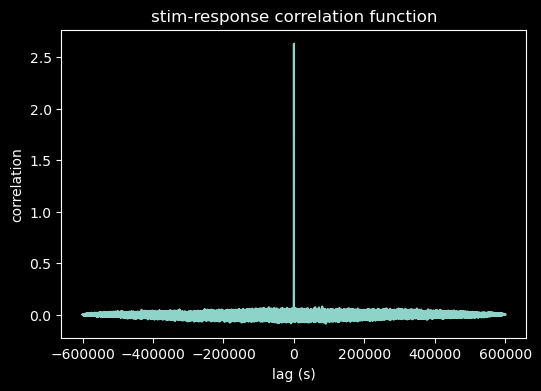

In [52]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(lags, qrs)
ax.set_xlabel('lag (s)')
ax.set_ylabel('correlation')
ax.set_title('stim-response correlation function')

In [53]:
# get STA
window = 300e-3
window_steps = int(window/dt8)
# initialize
sta_sum = np.zeros(window_steps)
num_spikes = np.sum(data['rho'])

# loop through spike train
for i in range(window_steps, len(data['rho'])):
    if data['rho'][i] == 1:
        # add stimulus preceding spike
        sta_sum += np.asarray(data['stim'][i - window_steps:i])
# get aveage
sta = sta_sum / num_spikes

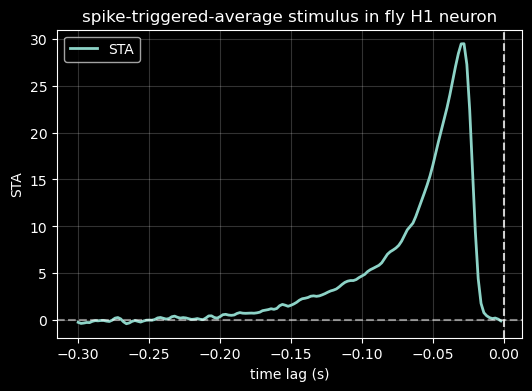

In [54]:
fig, ax = plt.subplots(figsize=(6, 4))

time_lags = np.linspace(-window, 0, window_steps, endpoint=False)

ax.plot(time_lags, sta, label='STA', linewidth=2)
ax.set_xlabel('time lag (s)')
ax.set_ylabel('STA')
ax.set_title('spike-triggered-average stimulus in fly H1 neuron')
ax.grid(which='both', alpha=0.2)
ax.axhline(0, linestyle='--', alpha=0.5)
ax.axvline(0, linestyle='--', alpha=0.8)
ax.legend()

## 9
using problem 8 data, calculate and plot stimulus averages triggered on events consisting a pair of spikes (not necessarily adjacent) separated by a given interval
- plot these two-spike-triggered average stimuli for various intevals ranging from 2 to 100 ms
- plot as a function of the separation between two spikes, the magnitude of difference between the 2STA and the sum of the two single-spike-STAs (from q8) separated by the same time interval
- at what temporal separation does this difference become negligibly small?

In [157]:
intervals = np.array([2e-3, 4e-3, 10e-3, 60e-3, 80e-3, 100e-3])

def get_2sta(data, interval, window_steps):
    spikes = data['rho']
    stim = data['stim']
    interval_steps = int(interval / dt8)
    
    pattern = [1] + [0] * (interval_steps - 1) + [1]
    convolved = np.convolve(spikes, pattern, mode='full')
    indices = np.where(convolved == 2)[0]

    sta2sum = np.zeros(window_steps)
    for i in indices:
        if i - window_steps >= 0:
            sta2sum += np.asarray(stim[i - window_steps:i])

    pair_count = len(indices)
    sta2 = sta2sum / pair_count if pair_count > 0 else np.zeros(window_steps)
    return sta2

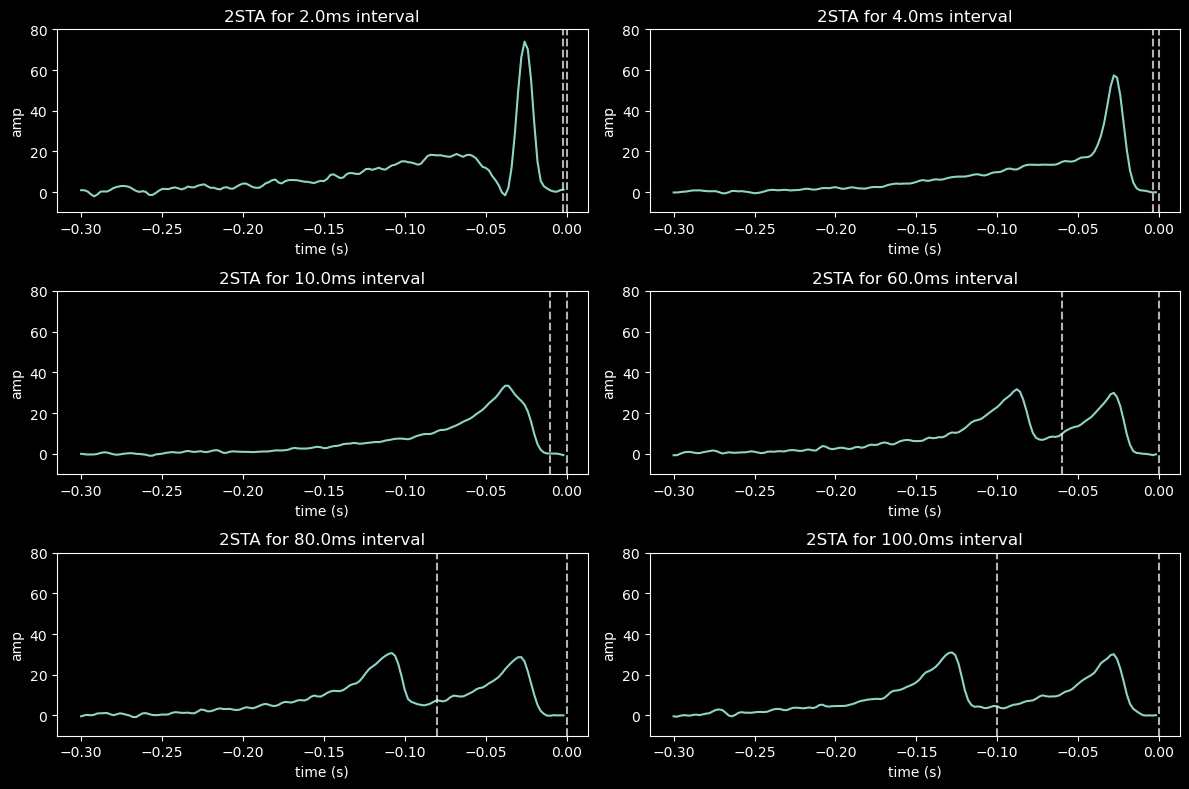

In [159]:
fig, axes = plt.subplots(3, 2, figsize=(12, 8))
window_size = 300e-3
window_steps = int(window_size / dt8)
time_lags = np.linspace(-window, 0, window_steps, endpoint=False)

for i, interval in enumerate(intervals):
    sta2 = get_2sta(data, interval, window_steps)

    row = i // 2
    col = i % 2

    ax = axes[row, col]
    ax.plot(time_lags, sta2)
    ax.set_ylim(-10, 80)
    ax.axvline(0, linestyle='--', alpha=0.7)
    ax.axvline(-interval, linestyle='--', alpha=0.7)
    ax.set_title(f'2STA for {np.round(interval*1000)}ms interval')
    ax.set_xlabel('time (s)')
    ax.set_ylabel('amp')

plt.tight_layout()